# Lesson 3 Assignment - Wine Classifier


## Author - Logan Downing
Datasci 420  
July 12, 2018

<img src="http://info.ncagr.gov/blog/wp-content/uploads/wineglass-1024x683.jpg" style="float:right;max-width:400px;margin-left:2rem">


### Instructions
Your task for this assignment:  Design a simple, low-cost sensor that can distinguish between red wine and white wine.
Your sensor must correctly distinguish between red and white wine for at least 95% of the samples in a set of 6497 test samples of red and white wine.

Your technology is capable of sensing the following wine attributes:
- Fixed acidity  
- Free sulphur dioxide
- Volatile acidity  
-  Total sulphur dioxide
- Citric acid  
-  Sulphates
- Residual sugar  
-  pH
- Chlorides  
- Alcohol
- Density




In [1]:
#f = "https://library.startlearninglabs.uw.edu/DATASCI420/Datasets/RedWhiteWine.csv"
f = 'RedWhiteWine.csv' # local version, in case URL goes away

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import seaborn as sns

# Acquire data, exploratory data analysis, and data transformation

In [3]:
# read in data
df = pd.read_csv(f)
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality        Class  
count  6497.000000  6497.000000  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801     5.818378     0.246114  
std       0.160787     0.148806     1.192712     0.873255     0.430779  
min       2.720000     0.220000     8.000000     3.000000     0.000000  
25%       3.110000     0.430000     9.500000     5.000000     0.000000  
50%       3.210000     0.510000    10.300000     6.000000     0.000000  
75%       3.320000     0.600000    11.300000     6.000000     0.000000  
max       4.010000     2.000000    14.900000     9.000000     1.000000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
Class                   6497 non-null int64
dtypes: float64(11), int64(2)
memory usage: 659.9 KB


Check out the distribution of the dependent variable

In [5]:
df.Class.value_counts()

0    4898
1    1599
Name: Class, dtype: int64

In [6]:
# drop quality columns, it is not needed
df.drop('quality',axis=1,inplace=True)

### Winsorize the data to diminish the effect of a few extreme values
A few extreme values skew some of the feature distributions a bit radically. Let's apply Winsorizing to all features and see how the distributions change.

In [7]:
# apply minor winsorizing to avoid a few very far-out outliers
from scipy.stats.mstats import winsorize
def winsorize_series(s):
    return winsorize(s,limits=(None,.005))

df_winsor = df.apply( winsorize_series, axis=0)

In [8]:
# a function to display a histogram of all features of a dataframe in a grid
def feature_grid(df,color='C0',title=""):
    
    fig,axes=plt.subplots(3,4,figsize=(15,10))
    i,j=0,0
    print(title)
    for feat in df.columns.values:

        plt.axes(axes[i,j])
        plt.hist(df[feat], edgecolor='silver', bins=30, label=feat, color=color)
        plt.legend()

        j+=1
        if(j>3):
            i+=1
            j=0 

**Original features**  
Note the large "value deserts" for 'residual sugar', 'chlorides', and 'density'

Original data


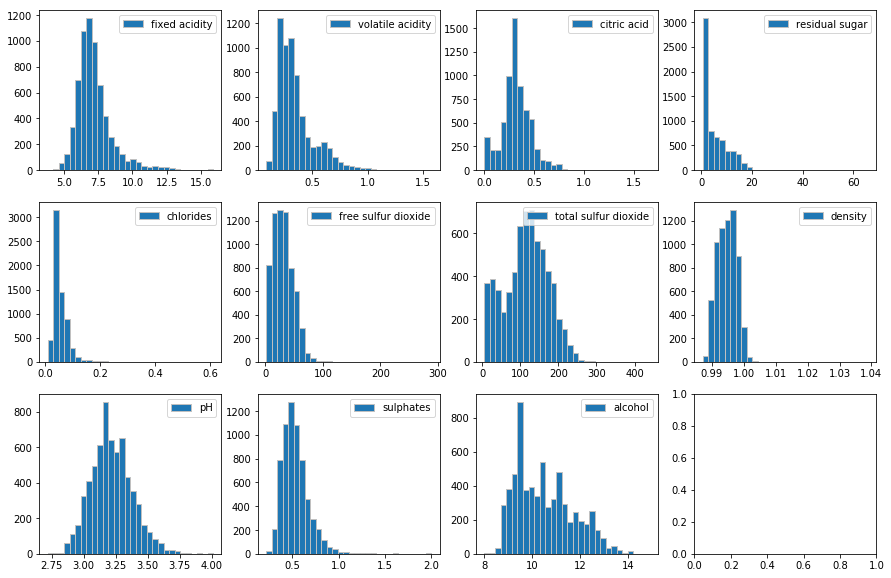

In [9]:
feature_grid(df.drop('Class',axis=1), title="Original data")
_=""

**Winsorized features**  
Notice how the features fill up nice ranges, now that extreme values have been Winsorized.

Winsorized data


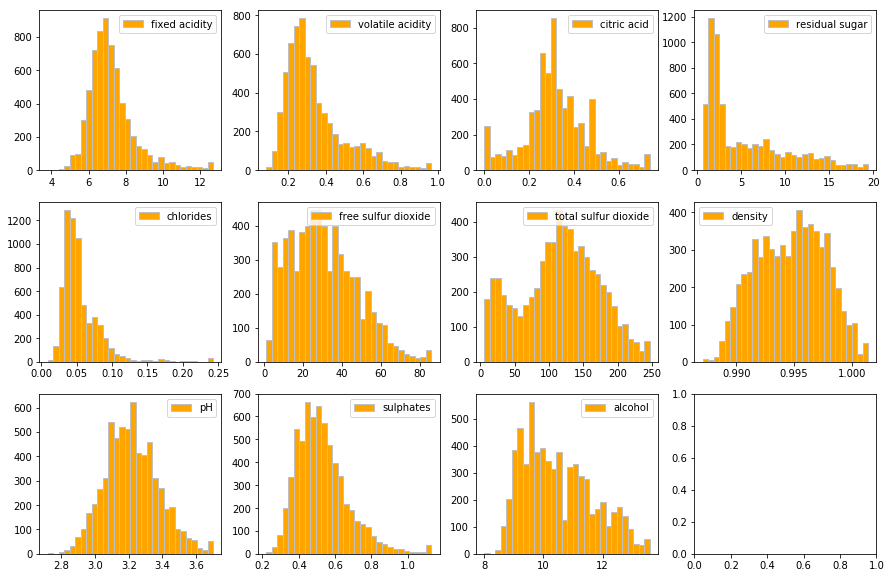

In [10]:
feature_grid(df_winsor.drop('Class',axis=1),color='orange', title="Winsorized data")
_=""

### Scale features  
Let's apply standard scaling to all our features, so that they exist on the same relative dimensions. This isn't so important for Naive Bayes modeling, but it won't hurt, and we might try some other model approaches that benefit from standardization. 

In [11]:
# split out features and targets
y = df.Class
X = df_winsor.drop('Class',axis=1)

In [12]:
# scale our features 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler() # MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
# I like to refer to our new scaled world as df_scaled (X_scaled with column labels):
df_scaled = pd.DataFrame( np.c_[X_scaled,y], index=df.index, columns=df.columns)
#df_scaled.head()

Note that the scaled feature distributions are the same as pre-scaled: we've just shifted the data to a mean of 0 and standard deviation of 1.

Scaled and normalized Winsorized data


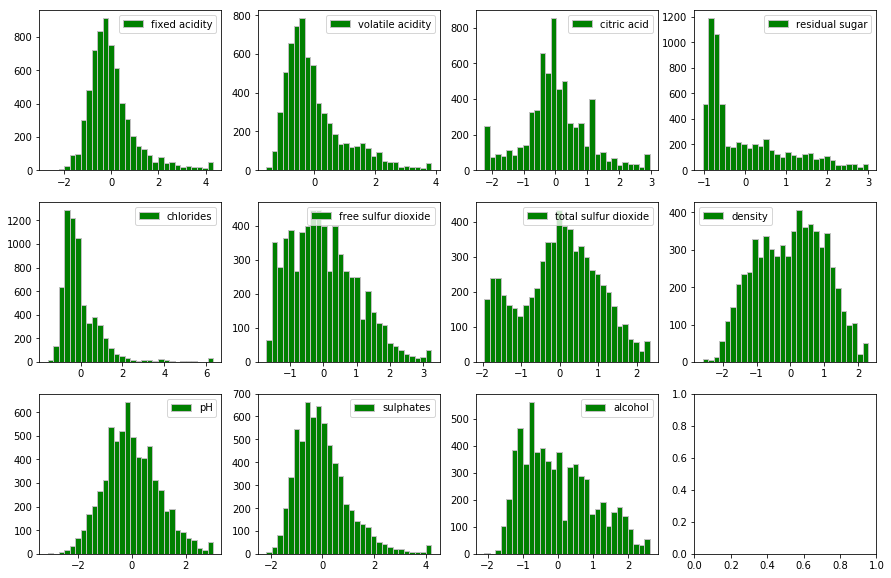

In [13]:
feature_grid(df_scaled.drop('Class',axis=1),color='green', title="Scaled and normalized Winsorized data")

### Examine correlations  
Check the 11 fields and see which are most correlated with the outcome. Also check which fields are most correlated with each other.

Absolute correlation values (np.abs()) of all 11 features and the dependent variable


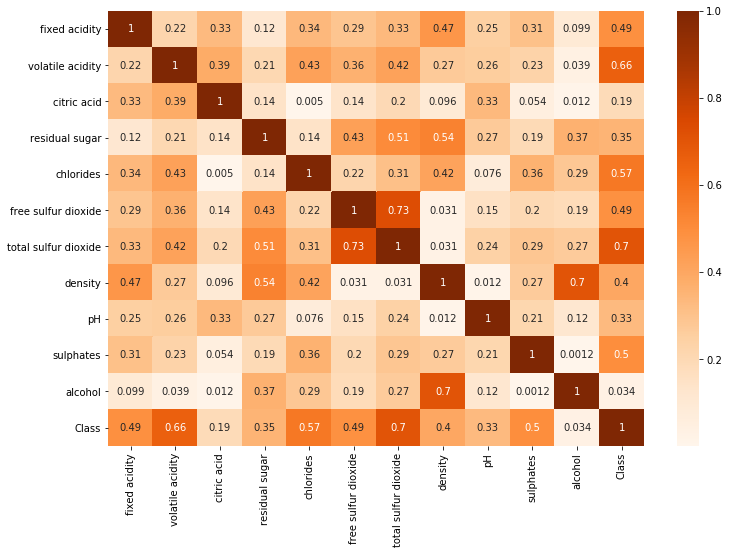

In [14]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(np.abs(df_scaled.corr()),cmap='Oranges',annot=True)
print("Absolute correlation values (np.abs()) of all 11 features and the dependent variable")
_=""

The correlation plot shows that some features are significantly correlated with each other (these will be candidates for feature reduction in our model):

* density & alcohol (70%)
* total sulfur dioxide & free sulfur dioxide (73%)



We also see which variables are least correlated with the dependent variable (these will be the first candidates for dropping out of our model):

* alcohol (3%)
* citric acid (19%)
* pH (33%)





Rank how the features are correlated with the dependent variable

In [15]:
fields_corr = np.abs(df_scaled.corr()['Class']).sort_values(ascending=False)[1:]
fields_corr

total sulfur dioxide    0.704821
volatile acidity        0.657802
chlorides               0.572728
sulphates               0.496707
fixed acidity           0.490022
free sulfur dioxide     0.485656
density                 0.400016
residual sugar          0.353676
pH                      0.329943
citric acid             0.189533
alcohol                 0.033635
Name: Class, dtype: float64

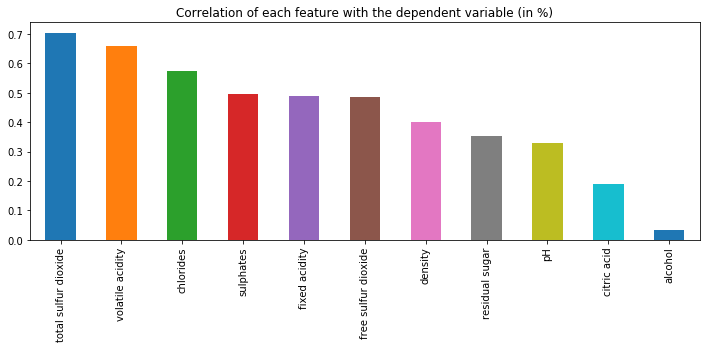

In [16]:
fields_corr.plot(kind='bar',figsize=(12,4), title="Correlation of each feature with the dependent variable (in %)")
_=""

We see there are four features which have correlations with the outcome of higher than 50%  (these will likely be superstar features in our model):

* total sulfur dioxide
* volatile acidity
* chlorides
* sulphates

# Baseline model (all features)  
Let's start the work with a blind assumption that all 11 features can be used for modeling and prediction. We'll use Gaussian Naive Bayes per the instructions. Note the algorithm assumes all features are independent, which we've seen isn't valid.

In [17]:
# try a naive bayes classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

### Split the data between train and test  
We'll use this split for the baseline model and all subsequent modeling afterwards.

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.33)

### Gaussian Naive Bayes  
First, let's get a sense how how well this model should perform, by running K-fold experiments on the training data.

In [19]:
# let's use kfold on the training data to see what kind of accuracy we're achieving
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
#kfolds = KFold(n_splits=20, shuffle=True)
kfolds = StratifiedKFold(n_splits=10, shuffle=True)
vals = cross_val_score( GaussianNB(), X_train, y_train, cv=kfolds, scoring='accuracy' )

print("Mean accuracy: {0:.1f}% with standard dev: {1:.2f}%".format(vals.mean()*100, vals.std()*100))

Mean accuracy: 97.9% with standard dev: 0.86%


Wow! Right off the bat we get 98% classification success using the Naive Bayes model on our training data. Our feature work, including Winsorizing and scaling, may have really helped out (probably mostly the Winsorizing).

Apply our baseline model to the test data. These outcomes are what we'll compare to other modeling work further down.

In [20]:
m = GaussianNB()
m.fit(X_train,y_train)

# make predictions on the test set
pred=m.predict(X_test)

# and print the performance
print("Classification report\n",classification_report(y_test,pred))
print("Confusion matrix\n",confusion_matrix(y_test,pred),"\n")
print("Accuracy (overall): {0:.1f}%".format(accuracy_score(y_test,pred)*100))

Classification report
              precision    recall  f1-score   support

          0       0.98      0.98      0.98      1630
          1       0.95      0.95      0.95       515

avg / total       0.98      0.98      0.98      2145

Confusion matrix
 [[1604   26]
 [  27  488]] 

Accuracy (overall): 97.5%


Good work. The Gaussian Naive Bayes model incorporating all eleven features (even those that are highly correlated with each other) performs really well on the test data set. Both classes are predicted at or above the 95% level. It'll be hard to improve on this.

### Receiver Operating Characteristic Curve  
Let's plot an ROC to get a sense of how well our model will perform under different discriminants. The AUC will help compare this baseline model with others, further down.

In [21]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

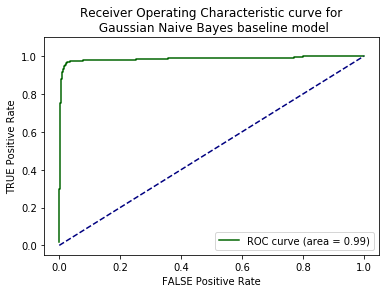

In [22]:
def plot_roc(y_test, y_prob, title=""):

    # Generate false positive & true positive rates using roc_curve() function
    fpr, tpr, th = roc_curve(y_test, y_prob) # False Positive Rate, True Posisive Rate, probability thresholds
    #print ("\nTP rates:", np.round(tpr, 2))
    #print ("\nFP rates:", np.round(fpr, 2))
    #print ("\nProbability thresholds:", np.round(th, 2))
    
    # Take a look at the ROC curve, and compute the AUC
    #print ("AUC score (using auc(fpr,tpr) function):", np.round(auc(fpr, tpr), 2))
    #print ("AUC score (using roc_auc_score(y_test,y_prob) function):", np.round(roc_auc_score(y_test, y_prob), 2), "\n")

    LW = 1.5 # line width for plots
    LL = "lower right" # legend location
    LC = 'darkgreen' # Line Color

    #plt.figure()
    plt.title(title or "Receiver Operating Characteristic curve")
    plt.xlim([-.05, 1.05])
    plt.ylim([-.05, 1.1])
    plt.xlabel('FALSE Positive Rate')
    plt.ylabel("TRUE Positive Rate")
    plt.plot(fpr, tpr, color=LC,lw=LW, label='ROC curve (area = {0:.2f})'.format(roc_auc_score(y_test, y_prob)))
    plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') # reference line for random classifier
    plt.legend(loc=LL)

# get probabilities for Class=1 for our test set...
y_prob = m.predict_proba(X_test)[:,1]    

# ...and calculate values for and show the roc curve
plot_roc(y_test, y_prob, title="Receiver Operating Characteristic curve for\n Gaussian Naive Bayes baseline model")    
_=""

The area under curve is nearly 1. The Gaussian Naive Bayes model incorporating all 11 features, and using the feature work we've done, performs very well.

### Compare to model without data transformation
It'd be interesting to compare these outstanding results with the same model using data that hasn't been scaled and transformed. This is just out of curiosity.

In [23]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  Class  
0      9.4      1  
1      9.8      1  
2      9.8      1  
3      9.8      1  
4      9.4      1

In [24]:
# split out the features of the original dataset
X_orig = df.drop('Class',axis=1)
y_orig = df.Class

# build the model on a training dataset. this split isn't the same as we use everywhere else;
# we're just doing a quick and easy look at this to get a feeling for how well (or poorly) modeling
# is for non-transformed data
X_orig_train,X_orig_test,y_orig_train,y_orig_test = train_test_split(X_orig,y_orig,test_size=.33)

m=GaussianNB()
m.fit(X_orig_train,y_orig_train)
pred=m.predict(X_orig_test)

# and print the performance
print("Classification report\n",classification_report(y_orig_test,pred))
print("Confusion matrix\n",confusion_matrix(y_orig_test,pred),"\n")
print("Accuracy (overall): {0:.1f}%".format(accuracy_score(y_orig_test,pred)*100))

Classification report
              precision    recall  f1-score   support

          0       0.99      0.97      0.98      1645
          1       0.90      0.97      0.93       500

avg / total       0.97      0.97      0.97      2145

Confusion matrix
 [[1589   56]
 [  14  486]] 

Accuracy (overall): 96.7%


Turns out the Gaussian Naive Bayes model on the unscaled, non-transformed data performs extremely well. With an overall accuracy of about 97%, it's 1% less sensitive than the baseline model.

# Feature reduction
Per the instructions, we want our sensor to be low-cost and easy to deploy. That means we need it to perform well, but to use as few features as possible. Ideally we only have to invest time in sampling a few features to get a 95% overall accuracy rate.  

The challenge is to find the smallest set of features that provide the 95% accuracy.

## Custom picking: Hand-selection of features
We have some information on the correlation of features with each other and with the dependent variable. Let's try hand-selecting sets of features to see the fewest we can get and still achieve 95% overall accuracy.




In [25]:
# first, reassemble dataframes for X_train and X_test (because right now they are just arrays)
df_X_train = pd.DataFrame( X_train, columns=df_scaled.drop('Class',axis=1).columns )
df_X_test  = pd.DataFrame( X_test, columns=df_scaled.drop('Class',axis=1).columns )
df_X_train.head(2)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.464264          1.609882    -0.406984       -0.734508   0.830308   
1      -0.244153          0.375723    -1.039294        1.602218  -0.756829   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.034941              0.274484  0.524723 -0.050875  -0.071275   
1             1.673151              1.255154  0.975604 -0.866387  -0.282722   

    alcohol  
0 -0.496693  
1 -0.917340


Recall the features most correlated with the dependent variable are:

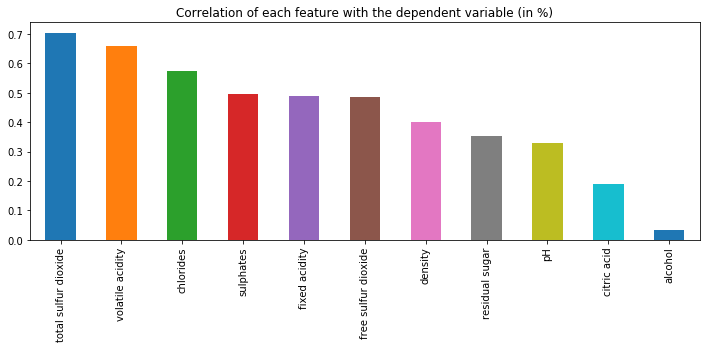

In [26]:
fields_corr.plot(kind='bar',figsize=(12,4), title="Correlation of each feature with the dependent variable (in %)")
_=""

And the fields that are most correlated with each other are:  

* density & alcohol (70%)
* total sulfur dioxide & free sulfur dioxide (73%)
    
    

Let's start with just the field that's most highly correlated with outcome

In [27]:
# let's try just a subset of the fields, the most correlated fields, and see what happens
#selected_fields = ['total sulfur dioxide','volatile acidity','chlorides','sulphates','fixed acidity','density','residual sugar']
selected_fields = ['total sulfur dioxide']
#df_X_train[selected_fields].head()

In [28]:
# and do a KFolds on the training data to get a sense of accuracy
kfolds = StratifiedKFold(n_splits=10, shuffle=True)
vals = cross_val_score( GaussianNB(), df_X_train[selected_fields], y_train, cv=kfolds, scoring='accuracy' )

print("Mean accuracy: {0:.1f}% with standard dev: {1:.2f}%".format(vals.mean()*100, vals.std()*100))

Mean accuracy: 92.4% with standard dev: 1.24%


Not good enough. Let's add the next-most correlated feature, volatile acidity.

In [29]:
selected_fields = ['total sulfur dioxide','volatile acidity']
vals = cross_val_score( GaussianNB(), df_X_train[selected_fields], y_train, cv=kfolds, scoring='accuracy' )

print("Mean accuracy: {0:.1f}% with standard dev: {1:.2f}%".format(vals.mean()*100, vals.std()*100))

Mean accuracy: 95.7% with standard dev: 1.04%


Reasonable. We've achieved 95% accuracy but the standard deviation of the KFold accuracy means has increased to over 1%. Let's get a little more consistent performance by adding the third-most correlated feature, chlorides.

In [30]:
selected_fields = ['total sulfur dioxide','volatile acidity','chlorides']
vals = cross_val_score( GaussianNB(), df_X_train[selected_fields], y_train, cv=kfolds, scoring='accuracy' )

print("Mean accuracy: {0:.1f}% with standard dev: {1:.2f}%".format(vals.mean()*100, vals.std()*100))

Mean accuracy: 95.8% with standard dev: 1.03%


Pretty good. We're at 96% overall accuracy, with a standard deviation (in Kfolds accuracy means) of about 1%. Out of curiosity, let's analyze the overall accuracy performance by running through all the features, in order of correlation to outcome. 


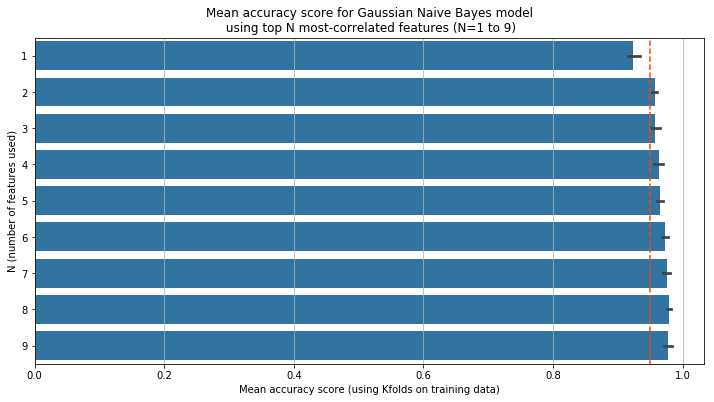

In [31]:
# possible fields, in decreasing order of correlation with the dependent variable. Note
# we exclude alcohol and free sulfur dioxide since those features are highly correlated to total sulfur dioxide
# and density, respectively.
fields = ['total sulfur dioxide','volatile acidity','chlorides','sulphates','fixed acidity','density','residual sugar','pH','citric acid']
selected_fields = []
means = [] #accumulate the means of Kfolds accuracies for various combos of fields
for field in fields:
    # add to selected_fields
    selected_fields.append(field)
    vals = cross_val_score( GaussianNB(), df_X_train[selected_fields], y_train, cv=kfolds, scoring='accuracy' )
    means.append(vals)
    
# and plot the results
plt.figure(figsize=(12,6))
plt.ylabel("N (number of features used)")
plt.xlabel("Mean accuracy score (using Kfolds on training data)")
sns.barplot(data=means,orient='h',color='C0')
plt.axvline(x=.95,linestyle="--",color='orangered')
plt.grid(axis='x')
plt.yticks(np.arange(9),np.arange(9)+1) # change ylabel to option base 1 
plt.title("Mean accuracy score for Gaussian Naive Bayes model\n using top N most-correlated features (N=1 to 9)")
_=""


Using the top 3 or more features gives a result that satisfies the 95% accuracy threshold. But starting with the top 4 features we get even better accuracy with lower variability. Let's go with the top 4 features for our hand-selected  model.

Create hand-selected model and compute performance.

In [32]:
# run our model on the test dataset and compute performance
selected_fields=['total sulfur dioxide','volatile acidity','chlorides','sulphates']
m = GaussianNB()
m.fit(df_X_train[selected_fields],y_train)

# get predictions
pred = m.predict(df_X_test[selected_fields])

# and print the performance
print("Classification report\n",classification_report(y_test,pred))
print("Confusion matrix\n",confusion_matrix(y_test,pred),"\n")
print("Accuracy (overall): {0:.1f}%".format(accuracy_score(y_test,pred)*100))


Classification report
              precision    recall  f1-score   support

          0       0.98      0.97      0.98      1630
          1       0.92      0.93      0.92       515

avg / total       0.96      0.96      0.96      2145

Confusion matrix
 [[1587   43]
 [  38  477]] 

Accuracy (overall): 96.2%


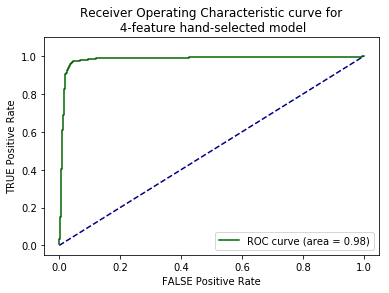

In [33]:
# get probabilities for Class=1 for our test set...
y_prob = m.predict_proba(df_X_test[selected_fields])[:,1]    

# ...and calculate values for and show the roc curve
plot_roc(y_test, y_prob, title="Receiver Operating Characteristic curve for\n 4-feature hand-selected model")  

Very good. Our hand-picked feature approach of 4 top features yields an overall accuracy of 96.6%, with an AUC of 0.98. The worst individual performer (precision and recall per outcome) is class 1 precision at 91%.

## Forward step-wise feature addition
So far we've evaluated the Gaussian Naive Bayes model using **all** features, and using the top 4 most-correlated features. We can try one more approach to see if we can find a smaller set of features that satisfies our operating conditions.

Let's try forward step-wise feature approach, where we build up the number of features based upon performance of adding each feature to the set and seeing which improves the model most.

In [34]:
# start with no features and a score of 0
best_score =0
best_fields = []
fields_to_test = set(['total sulfur dioxide','volatile acidity','chlorides','sulphates','fixed acidity','density','residual sugar','pH','citric acid'])

i=0
while fields_to_test and i<20:
    # loop over each field to test, add to current best set, and find its accuracy score
    candidate_scores=[]
    for candidate in fields_to_test:
        selected_fields = best_fields + [candidate] 
        #print("Testing:",selected_fields)
        
        # run the KFolds with these fields and get the mean f1 score
        vals = cross_val_score( GaussianNB(), df_X_train[selected_fields], y_train, cv=kfolds, scoring='accuracy' )
        candidate_scores.append( (vals.mean(), candidate) )
    
    candidate_scores.sort(reverse=True) 
    #print(candidate_scores)  
    test_score, test_candidate = candidate_scores.pop(0)
    if test_score>best_score:
        # we've found an improvement on our current best fields. 
        best_score = test_score
        best_fields.append(test_candidate)
        fields_to_test.remove(test_candidate)
    else:
        # no field improves our current best score and fields: quit
        print("\nCannot improve best feature set, stopping with these fields not used: ", fields_to_test)
        break
        
    i+=1
    print("Step {}. Best score: {:.3f}. Best fields: {}".format(i,best_score,best_fields))

Step 1. Best score: 0.924. Best fields: ['total sulfur dioxide']
Step 2. Best score: 0.962. Best fields: ['total sulfur dioxide', 'density']
Step 3. Best score: 0.974. Best fields: ['total sulfur dioxide', 'density', 'volatile acidity']
Step 4. Best score: 0.979. Best fields: ['total sulfur dioxide', 'density', 'volatile acidity', 'residual sugar']
Step 5. Best score: 0.987. Best fields: ['total sulfur dioxide', 'density', 'volatile acidity', 'residual sugar', 'sulphates']

Cannot improve best feature set, stopping with these fields not used:  {'fixed acidity', 'chlorides', 'citric acid', 'pH'}


In [35]:
# run our model on the test dataset and compute performance
selected_fields=best_fields
m = GaussianNB()
m.fit(df_X_train[selected_fields],y_train)

# get predictions
pred = m.predict(df_X_test[selected_fields])

# and print the performance
print("Classification report\n",classification_report(y_test,pred))
print("Confusion matrix\n",confusion_matrix(y_test,pred),"\n")
print("Accuracy (overall): {0:.1f}%".format(accuracy_score(y_test,pred)*100))

Classification report
              precision    recall  f1-score   support

          0       0.98      0.99      0.98      1630
          1       0.96      0.94      0.95       515

avg / total       0.98      0.98      0.98      2145

Confusion matrix
 [[1608   22]
 [  29  486]] 

Accuracy (overall): 97.6%


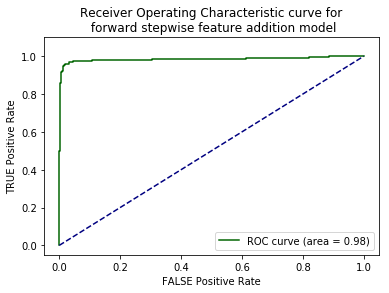

In [36]:
# get probabilities for Class=1 for our test set...
y_prob = m.predict_proba(df_X_test[selected_fields])[:,1]    

# ...and calculate values for and show the roc curve
plot_roc(y_test, y_prob, title="Receiver Operating Characteristic curve for\n forward stepwise feature addition model")  

Again, a very good result. The overall accuracy of our stepwise feature approach is 98.3%, with the worst performer being again class 1 precision at 96%. The algorithm picked out the best 5 fields to use, which turned out to be, in order:

1. **total sulfur dioxide**
2. density
3. **volatile acidity**
4. residual sugar
5. **sulphates**

The list includes three of the four "superstar" features we thought would be predictive (total sulfur dioxide,  volatile acidity and sulphates).

If we wanted to be frugal, we could stop at the first two features; constructing our model with them  just breaks the 95% overall accuracy threshold. Let's have a look at performance based on just these two top features.


In [37]:
# run our model on the test dataset and compute performance
selected_fields=['total sulfur dioxide','density']
m = GaussianNB()
m.fit(df_X_train[selected_fields],y_train)

# get predictions
pred = m.predict(df_X_test[selected_fields])

# and print the performance
print("Classification report\n",classification_report(y_test,pred))
print("Confusion matrix\n",confusion_matrix(y_test,pred),"\n")
print("Accuracy (overall): {0:.1f}%".format(accuracy_score(y_test,pred)*100))

vals = cross_val_score( GaussianNB(), df_X_train[selected_fields], y_train, cv=kfolds, scoring='accuracy' )
print(vals)

Classification report
              precision    recall  f1-score   support

          0       0.95      0.99      0.97      1630
          1       0.96      0.85      0.90       515

avg / total       0.95      0.95      0.95      2145

Confusion matrix
 [[1612   18]
 [  79  436]] 

Accuracy (overall): 95.5%
[ 0.96330275  0.97018349  0.96788991  0.96330275  0.97701149  0.93103448
  0.96091954  0.96781609  0.95391705  0.96313364]


The overall accuracy meets our 95% threshold. But the worst individual performer is class 1 recall at 84%. As we saw, by adding back in just a few more features, we can boost all the individual performers to 96% or greater.

# Principal component analysis
And finally, let's have a look at the problem using PCA analysis. We'll use PCA on all 11 original features to discover a reduced set of features that explain most of the variance.

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca = PCA() # start with an 11-component PCA so we can examine individual axis contributions.
# we fit over just training data; remember that test data is used for model comparison
pca.fit(df_X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Get a look at the explained variance per principal component

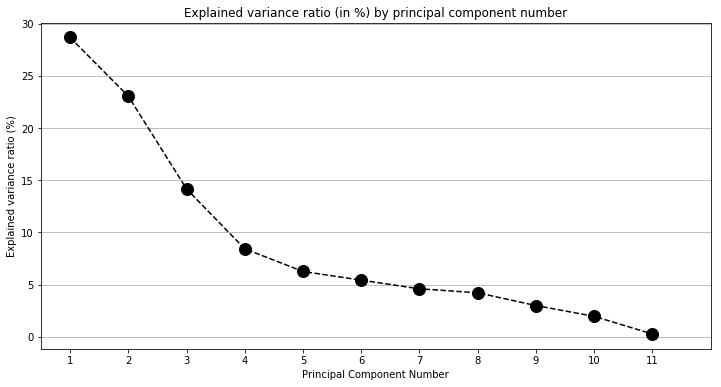

In [40]:
# number of principal components:
N_components = len(pca.components_)

# Plot the explained variance contributions for each of the 11 principal components
plt.figure(figsize=(12,6))
plt.grid(axis='y')

# plot points
plot_y = pca.explained_variance_ratio_ * 100
plt.plot(np.arange(1,N_components+1),plot_y,'ko--',markersize=12)
plt.xlim(.5,N_components+1)
plt.xticks( np.arange(1,N_components+1) ) # make all ticks show up
plt.title('Explained variance ratio (in %) by principal component number')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained variance ratio (%)')

# adjust scale so the first one doesn't dominate:
#plt.ylim(-plot_y[1]*.04,plot_y[1]*1.2)
_=""

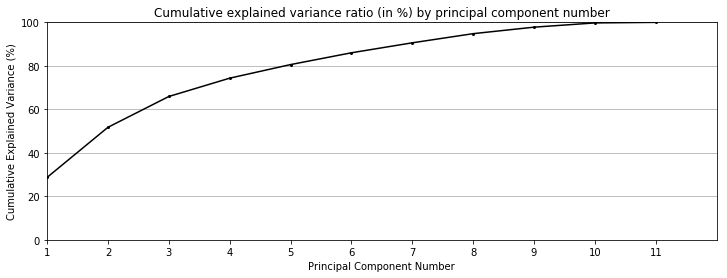

In [41]:
plt.figure(figsize=(12,4))
plt.grid(axis='y')
plt.plot([i+1 for i in range(df_X_train.shape[1])], pca.explained_variance_ratio_.cumsum()*100, 'ko-', markersize=2)
plt.xlim(1,N_components+1)
plt.ylim(0,100)
plt.xticks( np.arange(1,N_components+1) ) # make all ticks show up
plt.title('Cumulative explained variance ratio (in %) by principal component number')
plt.xlabel('Principal Component Number')
plt.ylabel('Cumulative Explained Variance (%)')
_=""

In [42]:
# looks like selecting the first two or three PCA components should do a pretty good job.
# if you choose 2 you can make a cool plot (smile)

Let's reduce to two principal axes and apply our PCA model over the training data to examine separability of the outcomes.

In [43]:
pca = PCA(n_components=2)
pca.fit(df_X_train)
x_pca=pca.transform(df_X_train) 
#x_pca

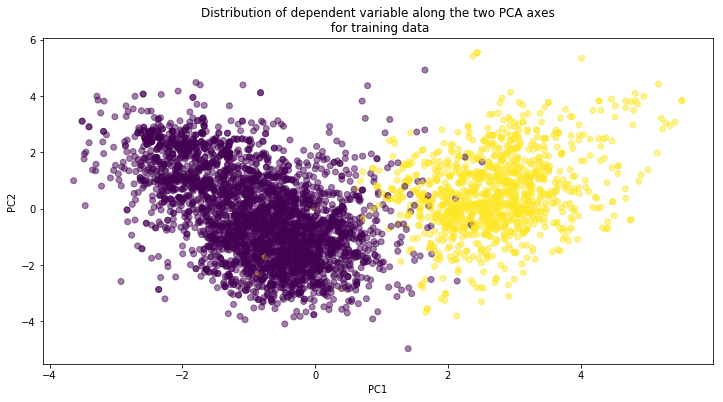

In [44]:
plt.figure(figsize=(12,6))
plt.scatter(x_pca[:,0], x_pca[:,1],c=y_train,alpha=.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Distribution of dependent variable along the two PCA axes\n for training data")
_=""

The data look quite separable using our 2-component PCA model. Let's continue and run the model with the test data, and calculate performance.

In [45]:
# run a GaussianNB on this dataset
m=GaussianNB()

# training data fits the model...
m.fit(x_pca,y_train)

# ...and test data for predictions
x_test_pca = pca.transform(X_test)
pred=m.predict(x_test_pca)

In [46]:
# and print the performance
print("Classification report\n",classification_report(y_test,pred))
print("Confusion matrix\n",confusion_matrix(y_test,pred),"\n")
print("Accuracy (overall): {0:.1f}%".format(accuracy_score(y_test,pred)*100))

Classification report
              precision    recall  f1-score   support

          0       0.98      0.99      0.99      1630
          1       0.98      0.94      0.96       515

avg / total       0.98      0.98      0.98      2145

Confusion matrix
 [[1618   12]
 [  31  484]] 

Accuracy (overall): 98.0%


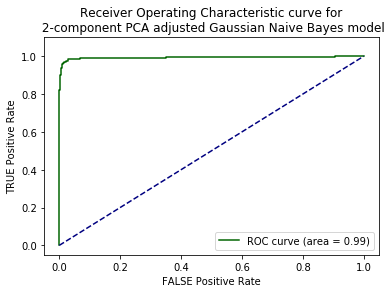

In [47]:
# get probabilities for Class=1 for our test set...
y_prob = m.predict_proba(x_test_pca)[:,1]    

# ...and calculate values for and show the roc curve
plot_roc(y_test, y_prob, title="Receiver Operating Characteristic curve for\n 2-component PCA adjusted Gaussian Naive Bayes model")  

Outstanding performance from the PCA model. We get an overall accuracy measure of 98%, and no individual performer (precision or recall on either outcome) is less than 96%. The performance of the PCA approach is similar to that of the 5-feature forward-selection model; however, it does require sampling 9 features and therefore is less attractive from a cost standpoint.

# Summary
The data were carefully analyzed and transformed by winsorizing and scaling.

We engineered our "sensor" using four different approaches to feature selection. Each approach was taken through a Gaussian Naive Bayes model. The accuracy scores and AUC values when applied to the test set are shown below.

Feature selection approach|# features|Overall accuracy|Area under curve|Worst individual performer
------|----------
Baseline|11 features|97.9%|.99|95% (precision for class 1)
Hand-picked| 4 features|96.6%|.98|91% (precision for class 1)
**Forward stepwise**| **5 features**|**98.3%**|**.99**|**96% (recall for class 1)**
2-component PCA| (all features)|98.2%|.99|95% (recall for class 1)

The "individual performers" are the values of precision and recall for each outcome class (four values in all). 

It must be said that all the models performed really well, with not a lot of work. This suggests the Gaussian Naive Bayes algorithm can really provide accurate predictions for certain classes of problems like this one.

#### Best performer

The best-performing model approach was using the five features chosen by forward stepwise feature selection. We can get 98% accuracy, with no individual performer less than 96%. This model best meets our need to get at least 95% accuracy while sampling the fewest number of features.

#### Worst performer

The "least"-performing model approach turned out to the one where we hand-pick the four features most correlated with outcome. This approach resulted in a 96.6% accuracy rate, with the worst individual performer at 91%.

I think the reason we got such great results really across the board has to do with the original handling of the data. We used winsorizing to reduce the effects of extreme values. This is important in Naive Bayes modeling because each feature's mean and standard deviation (per outcome class) directly generate the Gaussian curve which establishes probabilities. By "bunching" our data (by eliminating the excessive right tail) we get more natural summary statistics that describe the majority of the data well, and therefore work toward a better overall model.